In [1]:
import pandas as pd

In [5]:
# Load all 4 NYC weather datasets
weather_18 = pd.read_csv("18NYCweather.csv")
weather_19_20 = pd.read_csv("19-20NYCweather.csv")
weather_21_22 = pd.read_csv("21-22NYCweather.csv")
weather_23_24 = pd.read_csv("23-24NYCweather.csv")

# Combine them into one DataFrame
weather_all = pd.concat([weather_18, weather_19_20, weather_21_22, weather_23_24], ignore_index=True)

# Normalize column names (just in case)
weather_all.columns = weather_all.columns.str.strip().str.upper()

# Target NYC stations for filtering
target_stations = [
    "NY CITY CENTRAL PARK, NY US",
    "JFK INTERNATIONAL AIRPORT, NY US",
    "LAGUARDIA AIRPORT, NY US",
    "STATEN ISLAND 4.5 SSE, NY US",
    "BROOKLYN 3.1 NW, NY US",
    "QUEENS 3.4 NNW, NY US"
]

# Filter to only these station names
filtered_weather = weather_all[weather_all["NAME"].isin(target_stations)].copy()

# Convert DATE column to datetime format for merging later
filtered_weather["DATE"] = pd.to_datetime(filtered_weather["DATE"])

# Preview the filtered dataset
filtered_weather.head()


,STATION,NAME,DATE,AWND,DAPR,DASF,MDPR,MDSF,PGTM,PRCP,...,WSF5,WT01,WT02,WT03,WT04,WT05,WT06,WT08,WT09,WT11
1239,USW00014732,"LAGUARDIA AIRPORT, NY US",2018-01-01,17.00,NaN,NaN,NaN,NaN,NaN,0.00,...,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1240,USW00014732,"LAGUARDIA AIRPORT, NY US",2018-01-02,13.87,NaN,NaN,NaN,NaN,NaN,0.00,...,31.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1241,USW00014732,"LAGUARDIA AIRPORT, NY US",2018-01-03,6.93,NaN,NaN,NaN,NaN,NaN,0.00,...,27.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1242,USW00014732,"LAGUARDIA AIRPORT, NY US",2018-01-04,24.83,NaN,NaN,NaN,NaN,NaN,0.51,...,53.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
1243,USW00014732,"LAGUARDIA AIRPORT, NY US",2018-01-05,24.83,NaN,NaN,NaN,NaN,NaN,0.00,...,45.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:

beach_df = pd.read_csv("Swimming_Beach_Attendance_20250402.csv")
beach_df["Date"] = pd.to_datetime(beach_df["Date"])

# Create a mapping of beaches to their nearest weather station
beach_station_map = {
    "Coney Island Beach": "BROOKLYN 3.1 NW, NY US",
    "Rockaway Beach": "JFK INTERNATIONAL AIRPORT, NY US",
    "Wolfe's Pond Beach": "STATEN ISLAND 4.5 SSE, NY US",
    "Midland Beach": "STATEN ISLAND 4.5 SSE, NY US",
    "Manhattan Beach": "NY CITY CENTRAL PARK, NY US"
}

# Apply the mapping to the beach data
beach_df["Station"] = beach_df["Beach"].map(beach_station_map)

# Merge attendance data with weather data on Date and Station/Name
merged_df = pd.merge(
    beach_df,
    filtered_weather,
    left_on=["Date", "Station"],
    right_on=["DATE", "NAME"],
    how="left"
)

# Drop duplicate columns and clean up
merged_df.drop(columns=["DATE", "NAME"], inplace=True)

# Show merged data
merged_df.head()


,Date,Beach,Attendance,Station,STATION,AWND,DAPR,DASF,MDPR,MDSF,...,WSF5,WT01,WT02,WT03,WT04,WT05,WT06,WT08,WT09,WT11
0,2018-06-04,Rockaway Beach,7000,"JFK INTERNATIONAL AIRPORT, NY US",USW00094789,8.5,NaN,NaN,NaN,NaN,...,23.9,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-06-26,Wolfe's Pond Beach,120,"STATEN ISLAND 4.5 SSE, NY US",US1NYRC0001,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-07-08,Midland Beach,750,"STATEN ISLAND 4.5 SSE, NY US",US1NYRC0001,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-08-11,Coney Island Beach,86000,"BROOKLYN 3.1 NW, NY US",US1NYKN0025,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-06-05,Manhattan Beach,250,"NY CITY CENTRAL PARK, NY US",USW00094728,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Create useful weather-related feature flags for analysis

# 1. Rainy Day Flag: PRCP (precipitation) > 0
merged_df["Rainy_Day"] = merged_df["PRCP"].fillna(0) > 0

# 2. Hot Day Flag: TMAX (max temperature) >= 85°F (threshold can be adjusted)
merged_df["Hot_Day"] = merged_df["TMAX"].fillna(0) >= 85

# 3. Windy Day Flag: AWND (avg wind speed in mph) > 15
merged_df["Windy_Day"] = merged_df["AWND"].fillna(0) > 15

# 4. Weekend Flag (Saturday or Sunday)
merged_df["Weekend"] = merged_df["Date"].dt.dayofweek >= 5

# 5. Summer Season Flag (June 1 – August 31)
merged_df["Summer_Season"] = merged_df["Date"].dt.month.isin([6, 7, 8])

# Show the updated dataset with feature flags
merged_df.head()


,Date,Beach,Attendance,Station,STATION,AWND,DAPR,DASF,MDPR,MDSF,...,WT05,WT06,WT08,WT09,WT11,Rainy_Day,Hot_Day,Windy_Day,Weekend,Summer_Season
0,2018-06-04,Rockaway Beach,7000,"JFK INTERNATIONAL AIRPORT, NY US",USW00094789,8.5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,True,False,False,False,True
1,2018-06-26,Wolfe's Pond Beach,120,"STATEN ISLAND 4.5 SSE, NY US",US1NYRC0001,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,False,False,False,False,True
2,2019-07-08,Midland Beach,750,"STATEN ISLAND 4.5 SSE, NY US",US1NYRC0001,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,True,False,False,False,True
3,2019-08-11,Coney Island Beach,86000,"BROOKLYN 3.1 NW, NY US",US1NYKN0025,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,False,False,False,True,True
4,2020-06-05,Manhattan Beach,250,"NY CITY CENTRAL PARK, NY US",USW00094728,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,True,False,False,False,True


In [12]:
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar

# Load your dataset (if not already loaded)
# merged_df = pd.read_csv("your_merged_file.csv")  # If needed

# Ensure your date column is datetime
merged_df["Date"] = pd.to_datetime(merged_df["Date"])

# Create a date range for all dates in your dataset
date_range = pd.date_range(start="2018-01-01", end="2024-12-31")

# Get actual federal holiday dates
cal = USFederalHolidayCalendar()
holiday_dates = cal.holidays(start=date_range.min(), end=date_range.max())

# Create a DataFrame for merging
holiday_df = pd.DataFrame({"Date": holiday_dates, "Holiday": True})

# Merge with main dataset
merged_df = pd.merge(merged_df, holiday_df, on="Date", how="left")

# Fill in missing values (non-holidays) with False
merged_df["Holiday"] = merged_df["Holiday"].fillna(False)


,Date,Beach,Attendance,Station,STATION,AWND,DAPR,DASF,MDPR,MDSF,...,WT11,Rainy_Day,Hot_Day,Windy_Day,Weekend,Summer_Season,Holiday_x,date,Holiday_y,Holiday
0,2018-06-04,Rockaway Beach,7000,"JFK INTERNATIONAL AIRPORT, NY US",USW00094789,8.5,NaN,NaN,NaN,NaN,...,NaN,True,False,False,False,True,False,NaT,NaN,False
1,2018-06-26,Wolfe's Pond Beach,120,"STATEN ISLAND 4.5 SSE, NY US",US1NYRC0001,NaN,NaN,NaN,NaN,NaN,...,NaN,False,False,False,False,True,False,NaT,NaN,False
2,2019-07-08,Midland Beach,750,"STATEN ISLAND 4.5 SSE, NY US",US1NYRC0001,NaN,NaN,NaN,NaN,NaN,...,NaN,True,False,False,False,True,False,NaT,NaN,False
3,2019-08-11,Coney Island Beach,86000,"BROOKLYN 3.1 NW, NY US",US1NYKN0025,NaN,NaN,NaN,NaN,NaN,...,NaN,False,False,False,True,True,False,NaT,NaN,False
4,2020-06-05,Manhattan Beach,250,"NY CITY CENTRAL PARK, NY US",USW00094728,NaN,NaN,NaN,NaN,NaN,...,NaN,True,False,False,False,True,False,NaT,NaN,False


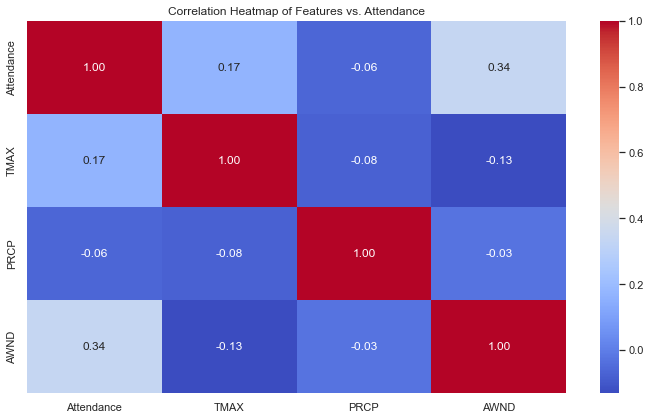

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# Only include numeric columns for correlation
numeric_df = eda_df.select_dtypes(include='number')

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Features vs. Attendance")
plt.tight_layout()
plt.show()


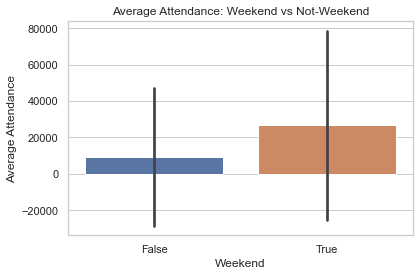

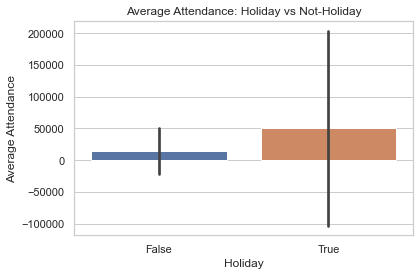

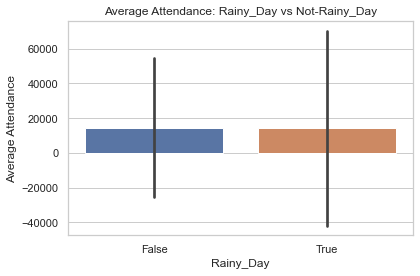

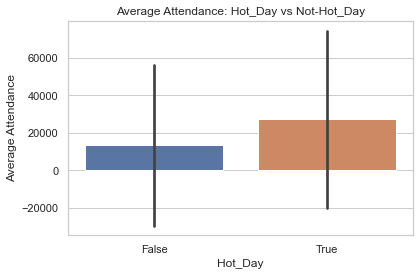

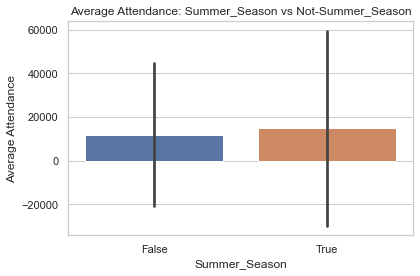

In [16]:
# Bar plots of average attendance by categorical features
categorical_flags = ["Weekend", "Holiday", "Rainy_Day", "Hot_Day", "Summer_Season"]

# Set plot style
sns.set(style="whitegrid")

# Create bar plots
for flag in categorical_flags:
    plt.figure(figsize=(6, 4))
    sns.barplot(data=merged_df, x=flag, y="Attendance", ci="sd")
    plt.title(f"Average Attendance: {flag} vs Not-{flag}")
    plt.ylabel("Average Attendance")
    plt.xlabel(flag)
    plt.tight_layout()
    plt.show()


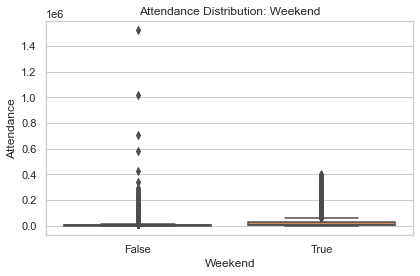

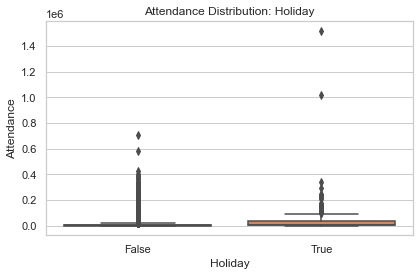

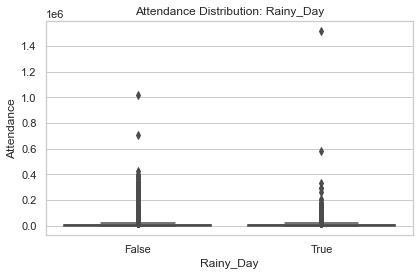

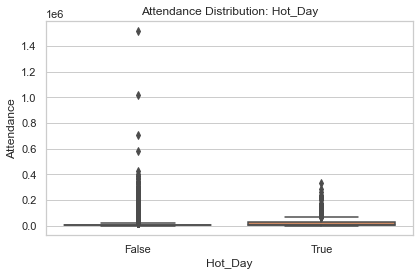

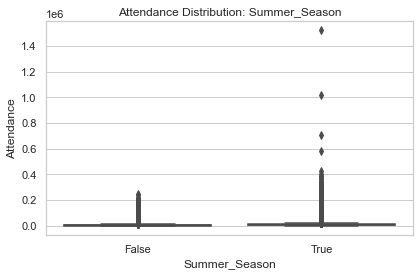

In [18]:
# Create boxplots to explore distribution and variability in attendance
for flag in categorical_flags:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=merged_df, x=flag, y="Attendance")
    plt.title(f"Attendance Distribution: {flag}")
    plt.ylabel("Attendance")
    plt.xlabel(flag)
    plt.tight_layout()
    plt.show()


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Step 1: Select features and target
feature_cols = ["TMAX", "AWND", "Rainy_Day", "Hot_Day", "Windy_Day", "Weekend", "Summer_Season", "Holiday"]
df_model = merged_df[feature_cols + ["Attendance"]].dropna()

# Convert boolean flags to integers (for regression)
for col in ["Rainy_Day", "Hot_Day", "Windy_Day", "Weekend", "Summer_Season", "Holiday"]:
    df_model[col] = df_model[col].astype(int)

# Step 2: Train-test split
X = df_model[feature_cols]
y = df_model["Attendance"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Fit linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Step 4: Predictions
y_pred = lr_model.predict(X_test)

# Step 5: Evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Coefficients for interpretation
coefficients = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": lr_model.coef_
}).sort_values(by="Coefficient", key=abs, ascending=False)

# Display results
metrics = pd.DataFrame({
    "Metric": ["MAE", "RMSE", "R²"],
    "Value": [mae, rmse, r2]
})



In [21]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np

# Reuse X_train, X_test, y_train, y_test from earlier split

# Step 1: Train XGBoost Regressor
xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
xgb_model.fit(X_train, y_train)

# Step 2: Predict
y_pred_xgb = xgb_model.predict(X_test)

# Step 3: Evaluate
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost MAE: {mae_xgb:.2f}")
print(f"XGBoost RMSE: {rmse_xgb:.2f}")
print(f"XGBoost R²: {r2_xgb:.2f}")

# Step 4: Feature importance
importance = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": xgb_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("\nFeature Importances:\n", importance)


XGBoost MAE: 12093.15
XGBoost RMSE: 22269.66
XGBoost R²: 0.52

Feature Importances:
          Feature  Importance
5        Weekend    0.395597
1           AWND    0.146705
7        Holiday    0.137918
0           TMAX    0.130966
2      Rainy_Day    0.123936
6  Summer_Season    0.064878
3        Hot_Day    0.000000
4      Windy_Day    0.000000
